# **Importing Essential Libraries**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# **Reading&preparing Data**

In [14]:
sales=pd.read_excel(r'/content/Fact_Sales.xlsx')
customers=pd.read_excel(r'/content/Dim_Customer.xlsx')
category=pd.read_excel(r"/content/Dim_Category.xlsx")
country=pd.read_excel(r"/content/Dim_Country1.xlsx")
date=pd.read_excel(r"/content/Dim_Date.xlsx")
location=pd.read_excel(r"/content/Dim_Location.xlsx")
product=pd.read_excel(r"/content/Dim_Product.xlsx")
subcategory=pd.read_excel(r"/content/Dim_SubCategory.xlsx")

In [15]:
# Merge fact and dimension tables
df = sales.merge(customers, on="CustomerID", how="left") \
               .merge(product, on="ProductID", how="left") \
               .merge(subcategory, on="SubCategoryID", how="left") \
               .merge(category, on="CategoryID", how="left") \
               .merge(location, on="LocationID", how="left") \
               .merge(country, on="CountryID", how="left")
df.head()



,InvoiceNo,InvoiceDate,CustomerID,ProductID,Quantity,UnitPrice,TotalAmount,Name,Gender,Age,...,Price,Cost,SubCategoryName,CategoryID,CategoryName,City,State,CountryID,Country,Region
0,INV0000001,2024-10-29,C1702,P023,5,671.66,3358.30,Fatma Ali,Female,56,...,671.66,495.79,Washing Machines,C02,Home Appliances,Riyadh,Riyadh,CT02,Saudi Arabia,Middle East
1,INV0000002,2025-01-16,C0338,P040,3,621.13,1863.39,Omar Khaled,Male,42,...,621.13,426.48,Washing Machines,C02,Home Appliances,Giza,Giza,CT01,Egypt,Middle East
2,INV0000003,2025-05-15,C0462,P077,5,825.61,4128.05,Robert Wilson,Male,53,...,825.61,655.62,Mobile Phones,C01,Electronics,Los Angeles,California,CT03,USA,North America
3,INV0000004,2025-05-01,C1750,P011,1,49.79,49.79,Mostafa Ali,Male,46,...,49.79,27.75,Fiction,C04,Books,Jeddah,Makkah,CT02,Saudi Arabia,Middle East
4,INV0000005,2025-07-16,C0427,P010,2,465.52,931.04,Ahmed Hassan,Male,51,...,465.52,406.45,Refrigerators,C02,Home Appliances,Dammam,Eastern,CT02,Saudi Arabia,Middle East


In [16]:
# Calculate IQR for TotalAmount
Q1 = df["TotalAmount"].quantile(0.25)
Q3 = df["TotalAmount"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df["TotalAmount"] >= lower_bound) & (df["TotalAmount"] <= upper_bound)]

print("Data after removing outliers:", len(df))


Data after removing outliers: 47002


In [17]:
df.shape

(47002, 24)

In [18]:
# Ensure InvoiceDate is datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# 2. Extract time features
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["Quarter"] = df["InvoiceDate"].dt.quarter

# 3. Aggregate monthly sales by category, gender, region
monthly_sales = df.groupby(
    ["Year", "Month", "Quarter", "CategoryName", "Gender", "Region"]
)["TotalAmount"].sum().reset_index()


In [19]:
# 4. Encode categorical variables
from sklearn.preprocessing import LabelEncoder

le_cat = LabelEncoder()
monthly_sales["CategoryName"] = le_cat.fit_transform(monthly_sales["CategoryName"])

le_gender = LabelEncoder()
monthly_sales["Gender"] = le_gender.fit_transform(monthly_sales["Gender"])

le_region = LabelEncoder()
monthly_sales["Region"] = le_region.fit_transform(monthly_sales["Region"])


# **Regression Model(Random Forest)**

In [20]:
# 5. Define features & target
X = monthly_sales[["Year", "Month", "Quarter", "CategoryName", "Gender", "Region"]]
y = monthly_sales["TotalAmount"]

# 6. Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [21]:
# 7. Train Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


In [22]:
# 8. Evaluate model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)


RMSE: 37761.116804161655
R² Score: 0.9237365589498336


/tmp/ipython-input-3691514909.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")


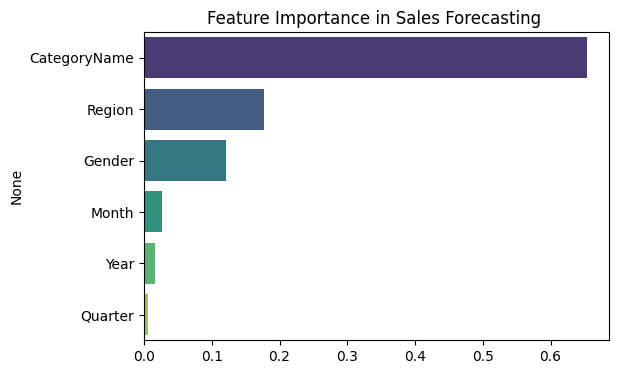

In [27]:
# 9. Feature importance
import matplotlib.pyplot as plt
import seaborn as sns

feat_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")
plt.title("Feature Importance in Sales Forecasting ")
plt.show()


## Predicting based on specific values

In [26]:
future_data = pd.DataFrame({
    "Year": [2025, 2025],
    "Month": [1, 2],
    "Quarter": [1, 2],
    "CategoryName": [le_cat.transform(["Electronics"])[0], le_cat.transform(["Clothing"])[0]],
    "Gender": [le_gender.transform(["Male"])[0], le_gender.transform(["Female"])[0]],
    "Region": [le_region.transform(["Europe"])[0], le_region.transform(["Middle East"])[0]]
})

future_predictions = rf_model.predict(future_data)
future_data["Predicted Sales"] = future_predictions
print(future_data)

   Year  Month  Quarter  CategoryName  Gender  Region  Predicted Sales
0  2025      1        1             2       1       0      113193.9953
1  2025      2        2             1       0       1       13052.1306
